In [4]:
import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import pandas as pd
import numpy as np
import seaborn as sns
from flask_app.function_api import load_dataset
pd.set_option("display.max_columns", None)
import nltk


In [5]:
# call function from function_api.py to load data from api datagrandest
df_dataset = load_dataset()

5932
6
https://www.datagrandest.fr/data4citizen/d4c/api/datasets/2.0/search/start=1&rows=1000
https://www.datagrandest.fr/data4citizen/d4c/api/datasets/2.0/search/start=1000&rows=1000
https://www.datagrandest.fr/data4citizen/d4c/api/datasets/2.0/search/start=2000&rows=1000
https://www.datagrandest.fr/data4citizen/d4c/api/datasets/2.0/search/start=3000&rows=1000


KeyboardInterrupt: 

In [ ]:
french_stopwords = nltk.corpus.stopwords.words('french')
mots = set(line.strip() for line in open('/home/dimitri/Documents/code/python/projet_ia_datagrand/dictionnaire.txt'))
lemmatizer = FrenchLefffLemmatizer()
def Preprocess_similarity(listofSentence):
 preprocess_list = []
 for sentence in listofSentence :
# Remove punctuation of sentence and lowercase it
  sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
# Remove digit on list of sentence 
  sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
# Tokenize word, Create a string for each word in the list of sentence
  tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num,language='french')
# Remove french stop words
  words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]
# Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item
  words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

  sentence_clean = ' '.join(w for w in words_w_stopwords if w.lower() in mots or not w.isalpha())

# Append to the empty list preprocess_list

  preprocess_list.append(sentence_clean)

 return preprocess_list

SyntaxError: invalid syntax (2743477318.py, line 14)

In [ ]:
documents_df = pd.DataFrame((df_dataset['title'].astype(str) + df_dataset['notes'].astype(str)+df_dataset['tags_name']),columns = ['documents'])
documents_df['documents'] = documents_df['documents'].str.replace('<[^<>]*>', '', regex=True)
data = documents_df.values.tolist()
document_df_cleaned =  Preprocess_similarity(data)

AttributeError: 'tuple' object has no attribute 'find'

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
data_words = list(sent_to_words(document_df_cleaned))

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View

In [ ]:
# number of topics
num_topics = 5# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics


In [ ]:
from gensim.models import CoherenceModel# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6015307895652061


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
visualization = gensimvis.prepare(lda_model, corpus, id2word)
render = pyLDAvis.save_html(
        visualization, 'LDAModel.html')

## Hyperparameters tuning

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import gensim.utils
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')# Validation sets
num_of_docs = len(corpus)

corpus_sets = [#gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
#                gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
                gensim.utils.ClippedCorpus(corpus, (int(num_of_docs*0.75))), 
                corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_new.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [34:08<00:00,  3.79s/it]


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
dataviz_hyparameters = pd.read_csv("/home/dimitri/Documents/code/python/projet_ia_datagrand/lda_tuning_results_new.csv")


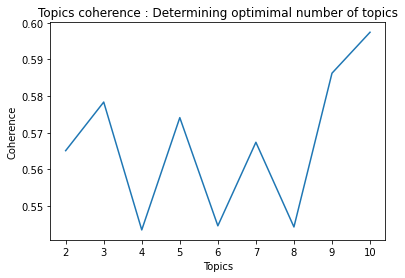

In [7]:
import seaborn as sns
ax = sns.lineplot(x="Topics", y="Coherence",data=dataviz_hyparameters,ci=None,markers= True,dashes=False).set(title='Topics coherence : Determining optimimal number of topics')
